# Brewing Chemistry

# Kaggle Overview

# Business Problem

# Data Understanding

# Import Libraries, Packages, and Environments

In [1]:
%%capture

import time
# Start the timer
start_time = time.time()

#Install Packages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark==3.0.1
!pip install tensorflow==2.8.0 #2.5.0
!pip install --upgrade keras
!pip install elephas==0.4.3
!pip install chempy

#Import libraries for system operations and environment management
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

import warnings
# Suppress only specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Suppress DeprecationWarnings

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

In [2]:
#Verify version for dependencies
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Python version:")
print(sys.version)
print()

TensorFlow version: 2.8.0
Keras version: 2.8.0
Python version:
3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]



In [3]:
# Start the timer
start_time = time.time()

# Import the necessary third party packages
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, split, lit, udf
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import Window
from pyspark.sql.functions import expr

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from google.colab import files
from google.colab import drive
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction
from chempy import Equilibrium, Substance
from scipy.optimize import fsolve
from collections import defaultdict
from chempy.chemistry import Species
from chempy.equilibria import EqSystem
from math import log10

# TensorFlow and Keras for deep learning (for future work)
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, serialize
from tensorflow.keras.utils import *
from tensorflow.python.keras.utils import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from elephas.utils.rdd_utils import to_simple_rdd
from elephas.spark_model import SparkModel
from elephas.ml_model import ElephasEstimator
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import serialize

# Set seaborn style for better visualizations
sns.set(style="whitegrid")

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

WARNING
Data transformation execution time: 1.65 seconds


# Notebook Architecture

The following code blocks establish the general setup architecture for the notebook. The Spark session can be initialized according to the computational resources available. Also, pickle functions are set to ease the computational resources by saving the state of an object to a disk, so that it can be reused later without having to recompute or recreate it.


In [4]:
# Start the timer
start_time = time.time()

conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]') # keep due to dependencies
#sc = SparkContext(conf=conf)

#comment or uncomment the code block that suits your computing architecture

# Initialize Spark session (default)
#spark = SparkSession.builder \
 #   .appName("Beer Quality Analysis") \
 #   .config("spark.sql.shuffle.partitions", "50") \
 #   .config("spark.executor.memory", "4g") \
 #   .config("spark.executor.cores", "4") \
 #   .getOrCreate()

# Initialize Spark session (optimized CPU)
#spark = SparkSession.builder \
 #   .appName("Beer Quality Analysis") \
 #   .config("spark.sql.shuffle.partitions", "50") \
 #   .config("spark.driver.memory", "8g") \
 #   .config("spark.executor.memory", "4g") \
 #   .config("spark.executor.cores", "2") \
 #   .config("spark.driver.maxResultSize", "4g") \
 #   .getOrCreate()

# Initialize the Spark session (optimized T4_GPU)
spark = SparkSession.builder \
    .appName("Beer Quality Analysis") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

# Print Spark configuration settings
spark.sparkContext.setLogLevel("DEBUG")
#spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")
print(spark.sparkContext.getConf().getAll())

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


[('spark.driver.port', '40427'), ('spark.driver.host', '85195d25589c'), ('spark.executor.id', 'driver'), ('spark.driver.memory', '16g'), ('spark.sql.shuffle.partitions', '100'), ('spark.executor.cores', '4'), ('spark.app.name', 'Beer Quality Analysis'), ('spark.driver.maxResultSize', '8g'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.executor.instances', '1'), ('spark.master', 'local[*]'), ('spark.executor.memory', '8g'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1722812286926'), ('spark.ui.showConsoleProgress', 'true')]
Data transformation execution time: 4.56 seconds


Explanation of Settings:

spark.sql.shuffle.partitions: This setting determines the number of partitions to use when shuffling data for operations such as joins or aggregations. A value of 50 is a recommended starting point for balancing performance and resource utilization.

spark.driver.memory: Allocates 8 GB of memory for the Spark driver, which is the main control node of your Spark application. This setting ensures that the driver has sufficient memory to manage the overall execution of the Spark jobs.

spark.executor.memory: Allocates 4 GB of memory for each Spark executor. Executors are the distributed agents that execute the tasks assigned by the driver. This setting ensures that each executor has adequate memory to perform its tasks efficiently.

spark.executor.cores: Allocates 2 CPU cores for each executor. This configuration helps in parallelizing tasks effectively, allowing the executors to handle multiple tasks concurrently.

spark.driver.maxResultSize: Sets a limit of 4 GB on the maximum size of results that can be collected to the driver. This prevents out-of-memory errors when collecting large results, ensuring the stability of the Spark application.


The following code block defines two functions to save and load models using pickle. The save_model function saves the model to a file, and the load_model function loads the model from a file. This helps save time by avoiding the need to recreate the model every time.

In [5]:
def save_model(model, filename):
    """
    Save the model to a file using pickle.

    Parameters:
    model : object
        The model to be saved.
    filename : str
        The name of the file where the model will be saved.
    """
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")

def load_model(filename):
    """
    Load the model from a file using pickle.

    Parameters:
    filename : str
        The name of the file from which the model will be loaded.

    Returns:
    object
        The loaded model.
    """
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model

# Import Data

In [6]:
# Start the timer
start_time = time.time()

# Load data set
beer_sample_set = spark.read.csv('sample_data/beer_sample_set.csv', header=True, inferSchema=True)

# Preview the dataset shape and first few rows
print("Dataset shape: Rows -", beer_sample_set.count(), " Columns -", len(beer_sample_set.columns))
print("Schema of the dataset:")
beer_sample_set.printSchema()

print("First few rows of the dataset:")
beer_sample_set.show(5)  # Show the first 5 rows

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Dataset shape: Rows - 250000  Columns - 20
Schema of the dataset:
root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)

First few rows of the data

# Preprocessing

Categorical, numeric, and mixed numeric values to be processed accordingly.

In [7]:
# Start the timer
start_time = time.time()

# Create a copy of the DataFrame to not alter original
beer_copy = beer_sample_set

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Data transformation execution time: 0.00 seconds


In [8]:
# Start the timer
start_time = time.time()

# Compute summary statistics
describe_df = beer_copy.describe()

# Show the summary statistics
describe_df.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

+-------+------------------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+----------------+----------------+------------------+------------------+------------------+--------------------+-------------------+------------------------+----------------------------+
|summary|          Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|             Gravity|    Alcohol_Content|        Bitterness|           Color|Ingredient_Ratio|   Volume_Produced|       Total_Sales|     Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+-------+------------------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+----------------+------------

Focusing on the column subset related to the chemical properties of beer, the pH seems consistently below 7. Average temperatue slightly  below room standard room temperature. The bitterness has a large standard deviation relative to the mean.

The standard metric taht will be used for this analysis of quality score seems to have a small standard deviation and the scores all seem  to be high in a range of 6-9.99 with an average score of 7.99.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

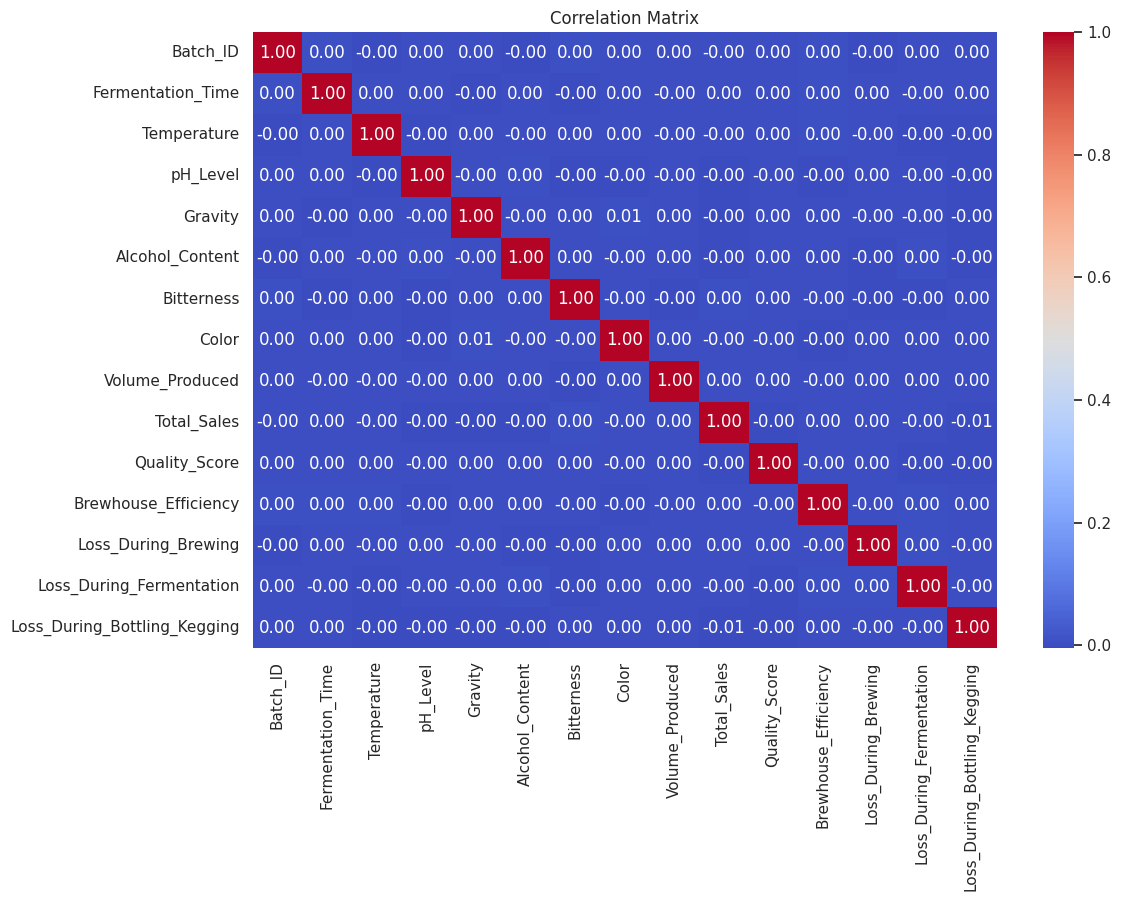

Data transformation execution time: 61.53 seconds


In [9]:
# Start the timer
start_time = time.time()

# Select numeric columns
numeric_columns = [field.name for field in beer_copy.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

# Compute the correlation matrix
corr_matrix = pd.DataFrame(columns=numeric_columns, index=numeric_columns)

for col1 in numeric_columns:
    for col2 in numeric_columns:
        corr_value = beer_copy.stat.corr(col1, col2)
        corr_matrix.at[col1, col2] = corr_value

# Convert the correlation matrix to float
corr_matrix = corr_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

# Save the plot as an image with better layout
filename = "all_data_correlation_matrix.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("all_data_correlation_matrix.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")



The most notable insight here is that the correlation plot seems to be completely uniform. Processing this data set will be challenging. To discover the relationships will require advanced techniques and deep domain knowledge.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

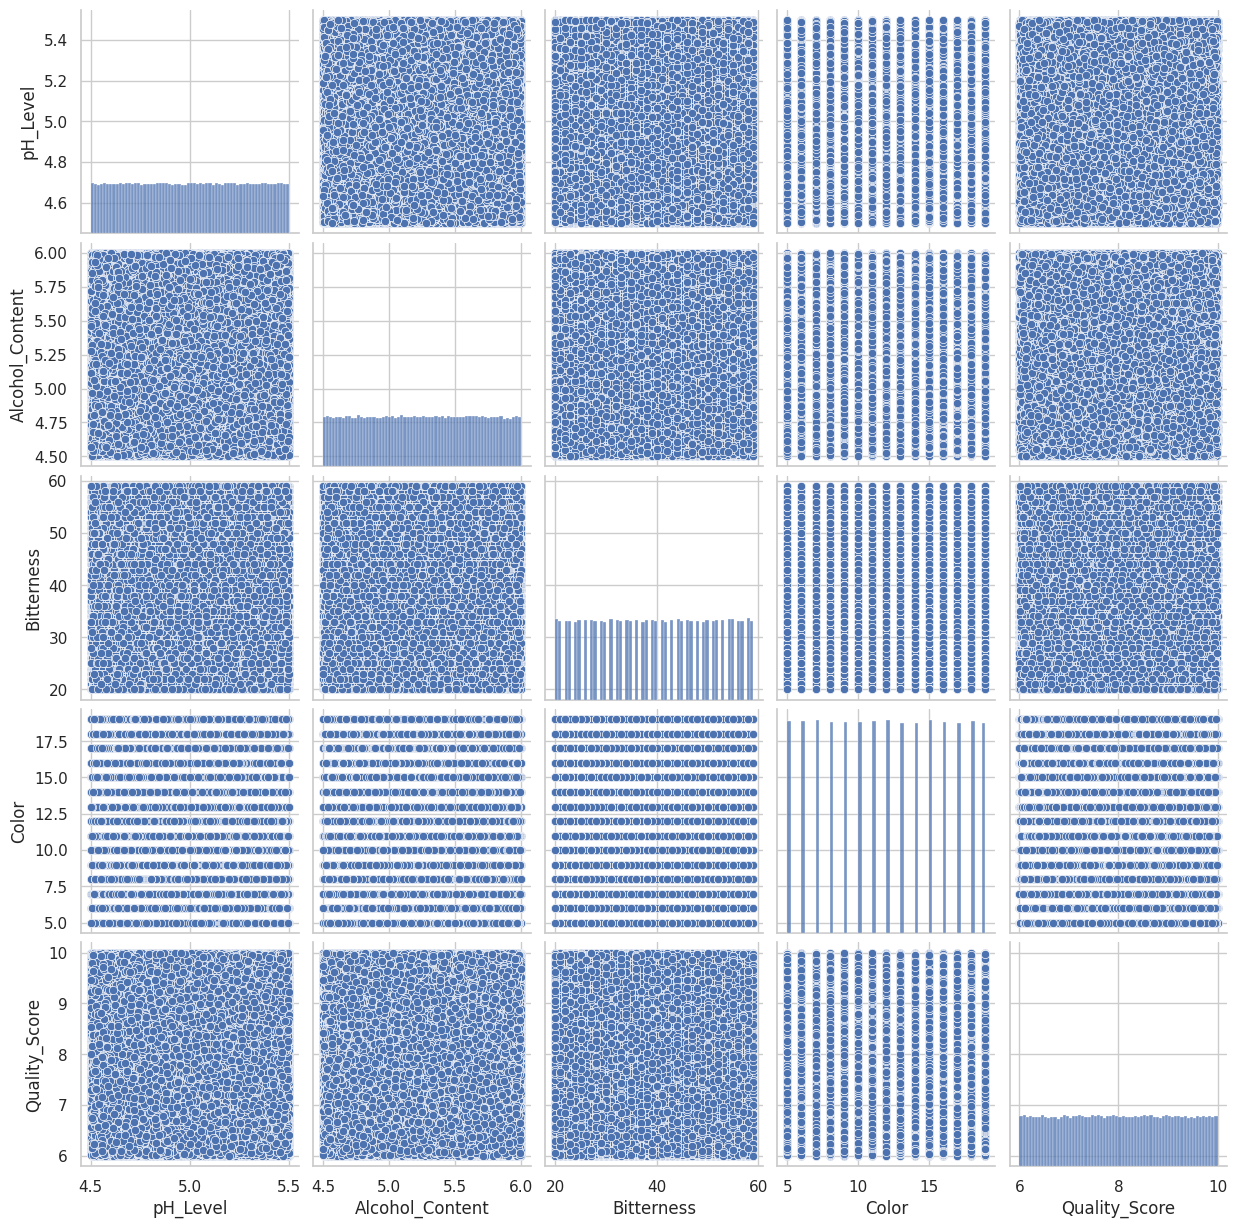

Data transformation execution time: 38.66 seconds


In [10]:
# Start the timer
start_time = time.time()

# Select relevant numerical columns
numeric_columns = ['pH_Level', 'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']

# Collect the data as a Pandas DataFrame
beer_sample_pandas = beer_copy.select(numeric_columns).toPandas()

# Plot the pair plot
sns.pairplot(beer_sample_pandas)

# Save the plot as an image with better layout
filename = "all_data_pair_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("all_data_pair_plot.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


This confirms the correlation plot consculsion. These pair plots show flat and uniform data. This shows how important this step in the preprocessing is because without these plots, it wouldn't be so obvious that the data set would be a challenge for finding relationships.

In [11]:
# Start the timer
start_time = time.time()

# Define the columns relevant for feature engineering (features that contain chemistry dependent properties)
relevant_columns = ['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature',
                    'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']
categorical_columns = ['Beer_Style']

# Create a subset of the data with relevant columns
beer_quality_predict = beer_copy.select(relevant_columns + categorical_columns)

# Preview the subset of the data
print("Subset of the data with relevant columns:")
beer_quality_predict.show(5)

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Subset of the data with relevant columns:
+-----------------+----------------+-----------------+------------------+-----------------+----------+-----+------------------+----------+
|         pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|  Alcohol_Content|Bitterness|Color|     Quality_Score|Beer_Style|
+-----------------+----------------+-----------------+------------------+-----------------+----------+-----+------------------+----------+
|4.944503974002884|     1:0.26:0.17|               15|15.070090125033419|5.104898993833054|        20|   19| 6.366748257130027|     Stout|
|5.403599353484238|     1:0.31:0.10|               19|15.563834668876087|5.075242393138411|        57|   14| 6.895412756770233|Wheat Beer|
|4.660538882478159|     1:0.32:0.21|               18|17.472288049501394|4.864122014861875|        20|    9| 6.964136947062722|      Sour|
|4.771273358916878|     1:0.32:0.24|               14|19.652671578475804|  5.8312391872117|        20|   19|6.68324419216492

This analysis will focus on the chemical properties of the beer making process that lead to top quality scores (cite reference for quality score as a metric - sales can also be used as a metric in a future analysis, consider brand building here). So here a chemical properties data subset is formed.

In [12]:
# Start the timer
start_time = time.time()

# Show schema of the DataFrame
beer_quality_predict.printSchema()

# Show summary statistics for numerical columns
beer_quality_predict.describe().show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


root
 |-- pH_Level: double (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Beer_Style: string (nullable = true)

+-------+------------------+----------------+-----------------+------------------+-------------------+------------------+----------------+------------------+----------+
|summary|          pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|    Alcohol_Content|        Bitterness|           Color|     Quality_Score|Beer_Style|
+-------+------------------+----------------+-----------------+------------------+-------------------+------------------+----------------+------------------+----------+
|  count|            250000|          250000|           250000|            250000|         

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

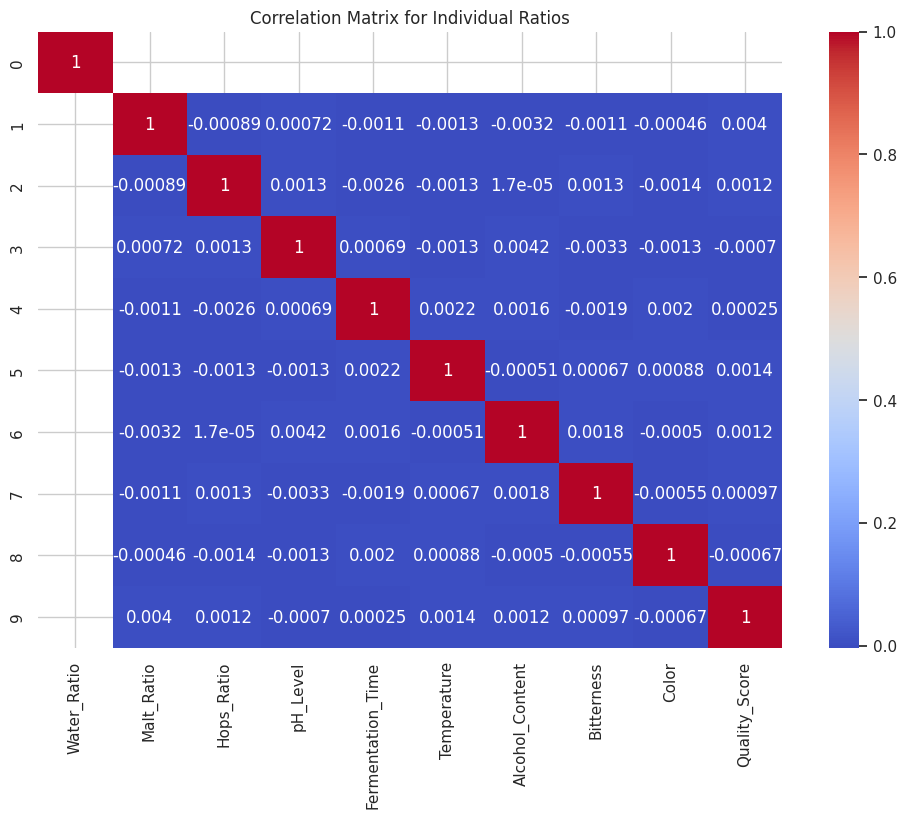

Data transformation execution time: 4.25 seconds


In [13]:
# Start the timer
start_time = time.time()

# Extract Individual Components
beer_quality_predict = beer_quality_predict.withColumn('Water_Ratio', lit(1.0))
beer_quality_predict = beer_quality_predict.withColumn('Malt_Ratio', split(col('Ingredient_Ratio'), ':').getItem(1).cast('float'))
beer_quality_predict = beer_quality_predict.withColumn('Hops_Ratio', split(col('Ingredient_Ratio'), ':').getItem(2).cast('float'))

# Assemble all relevant features into a vector
vector_col = 'features'
assembler = VectorAssembler(inputCols=['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                       'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score'], outputCol=vector_col)
df_vector = assembler.transform(beer_quality_predict).select(vector_col)

# Calculate Correlation Matrix
matrix = Correlation.corr(df_vector, vector_col).head()[0]
corr_matrix_indv = pd.DataFrame(matrix.toArray(), columns=['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                                                           'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score'])

# Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_indv, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Individual Ratios')

# Save the plot as an image with better layout
filename = "property_data_correlation_matrix.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("property_data_correlation_matrix.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Remarkably uniform. Traditional corelation matrices would show hints of a relationship. In this case, a deep dive into domain knowledge will be used to look closely for any relationships in the raw data.

In [14]:
# Start the timer
start_time = time.time()

# Create Combined Ratio Feature
beer_quality_predict = beer_quality_predict.withColumn('Malt_Hops_Ratio', col('Malt_Ratio') / col('Hops_Ratio'))

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Data transformation execution time: 0.02 seconds


The ingredient ratio of water, malt, and hops is crucial in brewing. Chemistry shows that water forms the base of the mixture, malt provides the sugars needed for fermentation, and hops add bitterness and aroma. Typically, water is present in the highest ratio, followed by malt, with hops being in the smallest ratio. In this analysis, we will create separate columns for the water, malt, and hops ratios, as well as a new feature column for the malt-to-hops ratio, to better understand their individual and combined effects on beer quality.



# Feature Engineering

We will infer new features based on existing data. The Malt_Type column will be created based on the beer's color, and the Hops_Type column will be derived from the beer's bitterness. These engineered features will then be one-hot encoded to prepare them for machine learning models.

In [15]:
# Start the timer
start_time = time.time()

# Function to infer malt type from color
beer_quality_predict = beer_quality_predict.withColumn(
    'Malt_Type',
    when(col('Color') < 10, 'Barley')
    .when((col('Color') >= 10) & (col('Color') < 20), 'Wheat')
    .when((col('Color') >= 20) & (col('Color') < 30), 'Rye')
    .otherwise('Oats')
)

# Function to infer hops type from bitterness
beer_quality_predict = beer_quality_predict.withColumn(
    'Hops_Type',
    when(col('Bitterness') > 40, 'Bittering')
    .when((col('Bitterness') > 20) & (col('Bitterness') <= 40), 'Dual Purpose')
    .otherwise('Aroma')
)

# Show the updated DataFrame with the new engineered features
beer_quality_predict.select('Color', 'Malt_Type', 'Bitterness', 'Hops_Type').show(5)

# One-hot encode categorical variables for machine learning models
categorical_columns = ['Beer_Style', 'Malt_Type', 'Hops_Type']

# Create a list to hold the stages of the Pipeline
stages = []

# Loop through each categorical column and create a StringIndexer and OneHotEncoder for each
for colm in categorical_columns:
    indexer = StringIndexer(inputCol=colm, outputCol=colm + '_Index')
    encoder = OneHotEncoder(inputCol=colm + '_Index', outputCol=colm + '_Vec')
    stages += [indexer, encoder]

# Apply the stages of the Pipeline to the DataFrame
pipeline = Pipeline(stages=stages)
beer_encoded = pipeline.fit(beer_quality_predict).transform(beer_quality_predict)

# Show the resulting DataFrame with the one-hot encoded columns
print("One-hot encoded dataframe:")
beer_encoded.select([colm for colm in beer_encoded.columns if 'Vec' in colm]).show()

# Preview the entire DataFrame
beer_encoded.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


+-----+---------+----------+------------+
|Color|Malt_Type|Bitterness|   Hops_Type|
+-----+---------+----------+------------+
|   19|    Wheat|        20|       Aroma|
|   14|    Wheat|        57|   Bittering|
|    9|   Barley|        20|       Aroma|
|   19|    Wheat|        20|       Aroma|
|   17|    Wheat|        37|Dual Purpose|
+-----+---------+----------+------------+
only showing top 5 rows

One-hot encoded dataframe:
+--------------+-------------+-------------+
|Beer_Style_Vec|Malt_Type_Vec|Hops_Type_Vec|
+--------------+-------------+-------------+
| (7,[2],[1.0])|(1,[0],[1.0])|    (2,[],[])|
| (7,[0],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|
| (7,[3],[1.0])|    (1,[],[])|    (2,[],[])|
| (7,[6],[1.0])|(1,[0],[1.0])|    (2,[],[])|
| (7,[4],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
| (7,[2],[1.0])|    (1,[],[])|(2,[0],[1.0])|
| (7,[0],[1.0])|    (1,[],[])|(2,[0],[1.0])|
| (7,[5],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
| (7,[2],[1.0])|(1,[0],[1.0])|(2,[1],[1.0])|
|     (7,[],[])|    (1,[],[])|

Using reference literature on beer making, hops and malt types can be inferred based on the beer's color and bitterness. In brewing, the color of the beer, which ranges from pale yellow to dark brown, is primarily influenced by the type and amount of malt used. Malt provides fermentable sugars and contributes to the beer's flavor and body.

Hops, known for their bitterness and aromatic qualities, counterbalance the sweetness of the malt. The bitterness level, often measured in International Bitterness Units (IBUs), indicates the type of hops used. Chemistry plays a crucial role in understanding these properties, as different malts and hops impart specific flavors, aromas, and colors through their unique chemical compositions.

By analyzing these characteristics, brewers can predict the type of malt and hops used in a beer, enabling them to replicate or innovate on traditional recipes.

The temperature split turned out not to be a useful metric because the category values overlap so Beer_Style cannot be clearly delineated at this point.

Ales: 62-75 °F (17-24 °C)
Lagers: 46-58 °F (8-14 °C) #assume dark lagers in this project
Wheat and Belgian styles: 62-85 °F (17-29 °C), ales divided into these categories
<br>

Next let's take a look at whether or not the Beer_Style feature distribute consistently into the Fermentation_Time feature.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

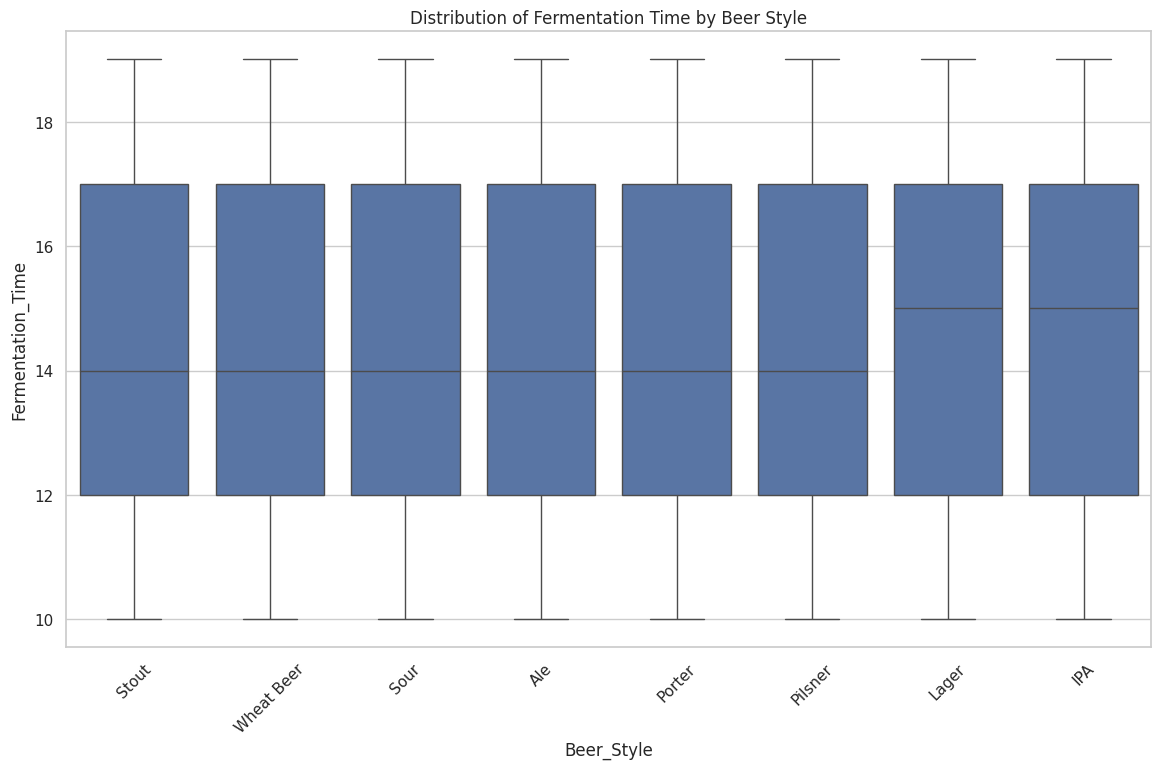

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

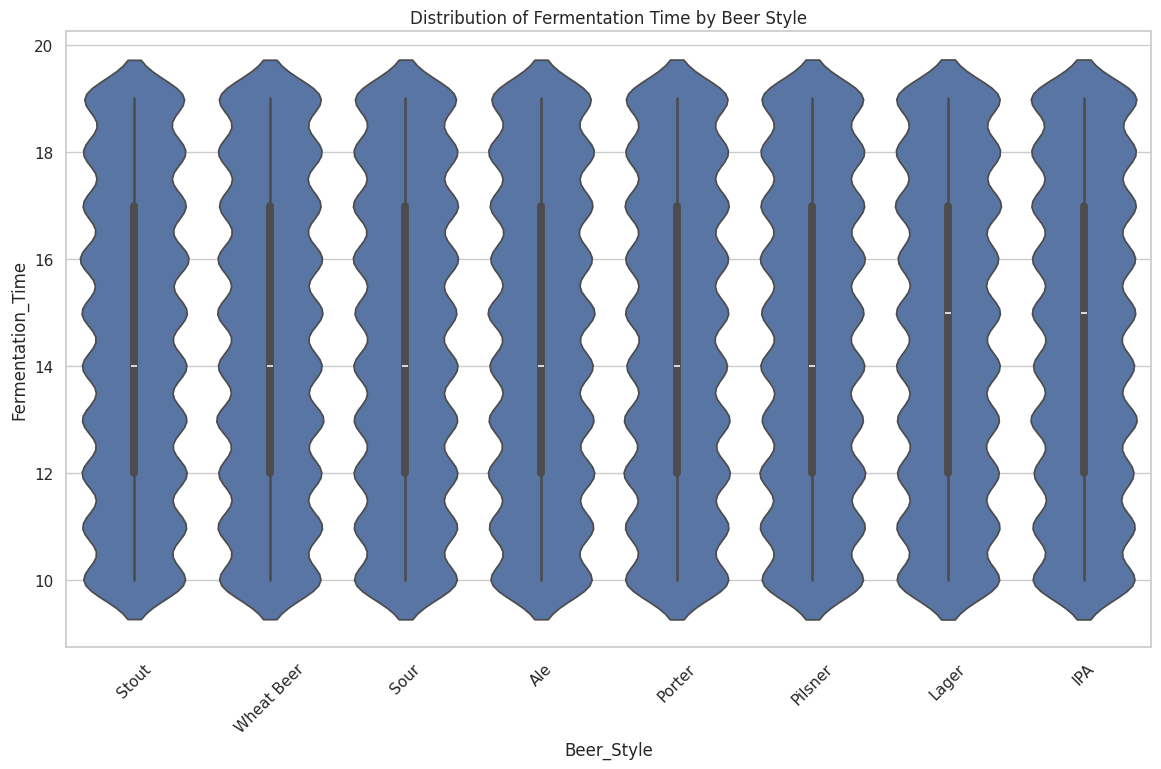

Data transformation execution time: 3.64 seconds


In [16]:
# Start the timer
start_time = time.time()

# Extract relevant columns
ferment_style_comp = beer_quality_predict.select('Beer_Style', 'Fermentation_Time')

# Convert to Pandas DataFrame for plotting
ferment_style_comp_pd = ferment_style_comp.toPandas()

# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp_pd)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)

# Save the plot as an image with better layout
filename = "fermentation_style_box_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("fermentation_style_box_plot.jpg")

# Show the plot
plt.show()

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp_pd)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)

# Save the plot as an image with better layout
filename = "fermentation_style_violin_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("fermentation_style_violin_plot.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

This discrete data is based on 250,000 data points and shows that Lager and IPA have an increased fermentation time due to the chemistry involved. Lager yeasts ferment at lower temperatures and more slowly, allowing for the development of clean, crisp flavors. IPAs, with their higher hop content, require extended fermentation to balance the bitterness and develop the complex hop aromas and flavors through biochemical reactions.

Generally, the plots show that the fermentation times for different beer styles are consistent; with median values around 15-16 days and a range between approximately 10 and 18 days. This is evident from the box plot and violin plot, which both show similar distributions across beer styles. The similar interquartile ranges indicate that the central 50% of the data points for each style lie within a comparable range. The density of data points around the median values, as shown in the violin plot, reinforces this observation.

This data suggests that while specific styles like Lager and IPA may have increased fermentation times due to their unique chemistry, the overall process duration is quite uniform across various beer styles.

# Unsupervised Learning

This experiment explores clustering models with a K-means experiment. To determine the optimal cluster grouping number inertia and silhouette scores will be used.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

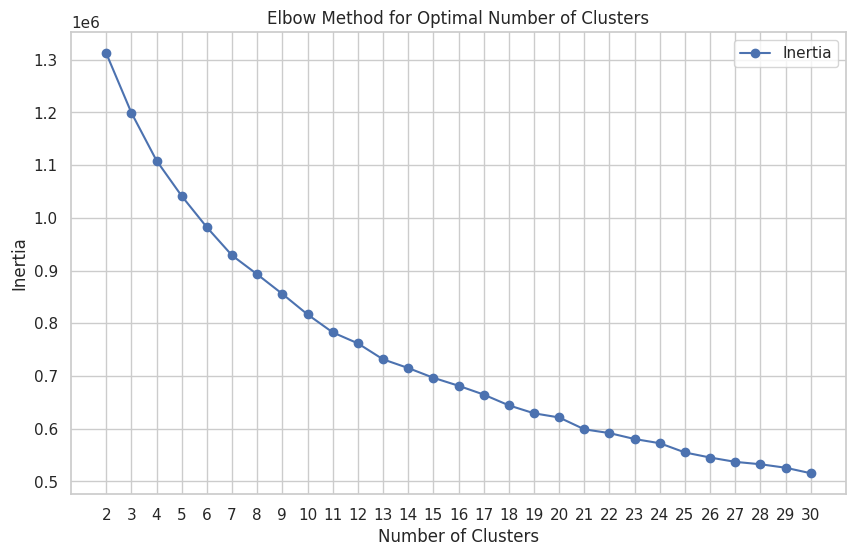

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

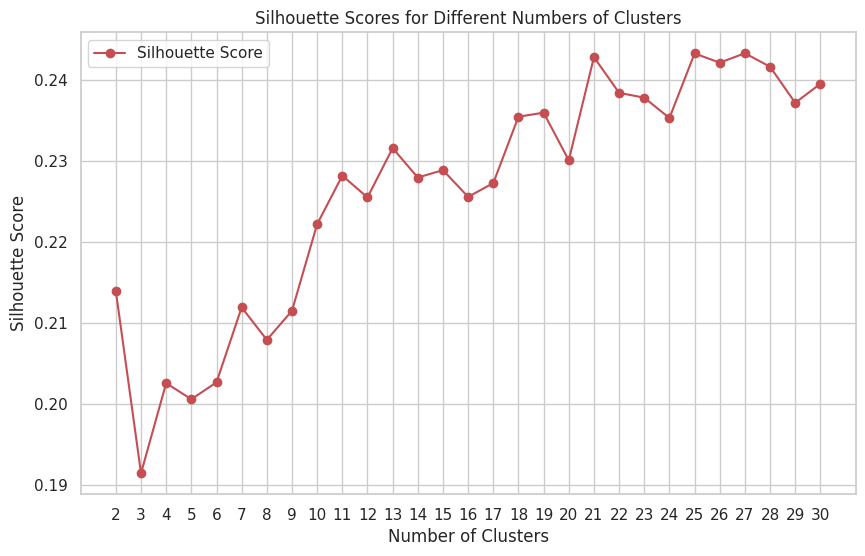

Data transformation execution time: 160.24 seconds


In [17]:
# Start the timer
start_time = time.time()

# Select relevant features for clustering
clustering_features = ['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features")
beer_assembled = assembler.transform(beer_encoded)

# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(beer_assembled)
beer_scaled = scaler_model.transform(beer_assembled)

# Define the range of clusters to test
min_clusters = 2
max_clusters = 30

# Store inertia and silhouette scores for different cluster sizes
inertia_values = []
silhouette_scores = []

# ClusteringEvaluator to calculate silhouette scores
evaluator = ClusteringEvaluator(featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

# Iterate over the range of clusters
for k_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(k=k_clusters, seed=42, featuresCol="scaled_features")
    kmeans_model = kmeans.fit(beer_scaled)

    # Make predictions
    predictions = kmeans_model.transform(beer_scaled)

    # Append inertia (sum of squared distances to nearest cluster center)
    inertia_values.append(kmeans_model.summary.trainingCost)

    # Calculate silhouette score
    silhouette_avg = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_avg)

# Plot the inertia values to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertia_values, marker='o', linestyle='-', color='b', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.legend()

# Save the plot as an image with better layout
filename = "elbow_cluster_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("elbow_cluster_plot.jpg")

# Show the plot
plt.show()

# Plot the silhouette scores to further validate the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', color='r', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.legend()

# Save the plot as an image with better layout
filename = "silhouette_cluster_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("silhouette_cluster_plot.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Through analysis, 27 has been identified as the optimal number of clusters. The Inertia score shows a plateau, indicating minimal improvement in compactness of clusters beyond 27. Additionally, the Silhouette score peaks at 27, indicating the highest average separation between clusters.

The calculations support each other and the determination that 27 is the optimal number of clusters.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

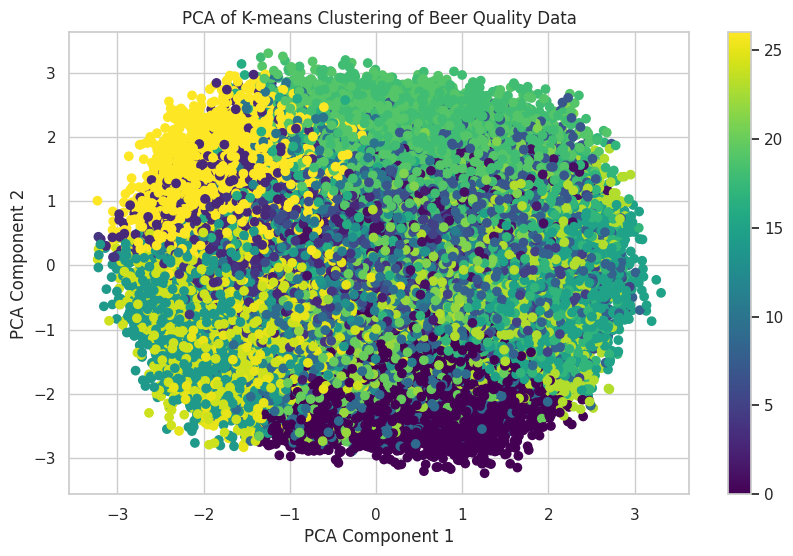

Data transformation execution time: 27.86 seconds


In [18]:
# Start the timer
start_time = time.time()

# Select relevant features for clustering
clustering_features = ['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=clustering_features, outputCol='features')
beer_assembled = assembler.transform(beer_encoded)

# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(beer_assembled)
beer_scaled = scaler_model.transform(beer_assembled)

# Apply KMeans clustering
num_clusters = 27  # Specify the number of clusters
kmeans = KMeans(k=num_clusters, seed=42, featuresCol='scaled_features', predictionCol='Cluster')
kmeans_model = kmeans.fit(beer_scaled)

# Transform the data using the fitted KMeans model
beer_clustered = kmeans_model.transform(beer_scaled)

# Apply PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
pca_model = pca.fit(beer_clustered)
beer_pca = pca_model.transform(beer_clustered)

# Convert to Pandas for visualization
beer_pca_pd = beer_pca.select("pcaFeatures", "Cluster").toPandas()
beer_pca_pd[['pca1', 'pca2']] = pd.DataFrame(beer_pca_pd['pcaFeatures'].tolist(), index=beer_pca_pd.index)

# Plot the PCA results with clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(beer_pca_pd['pca1'], beer_pca_pd['pca2'], c=beer_pca_pd['Cluster'], cmap="viridis")
plt.colorbar(scatter)
plt.title('PCA of K-means Clustering of Beer Quality Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Save the plot as an image with better layout
filename = "PCA_clustering.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("PCA_clustering.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

This plot represents the Principal Component Analysis (PCA) of K-means clustering applied to the beer quality dataset. The PCA reduces the dimensionality of the data, projecting it onto two principal components, allowing the visualization of clustering results in a 2D space. The color gradient indicates the quality score, with darker colors representing lower quality scores and lighter colors representing higher quality scores.

**Several key observations can be made from this visualization:**

Cluster Density and Overlap:

The plot shows a dense overlap of clusters, indicating that the data points are closely packed together in this 2D space. This suggests that while K-means has identified distinct clusters, there is still significant overlap between them, which could be due to the inherent complexity and similarities within the beer quality dataset.

Quality Distribution:

The color gradient reveals how the quality scores are distributed across the clusters. The presence of different colors within the same clusters indicates variability in beer quality within those clusters. However, some regions show a concentration of higher or lower quality scores, suggesting that certain clusters may correspond to specific quality levels more strongly.

PCA Components Interpretation:

The PCA components represent combinations of the original features that capture the most variance in the data. The distribution of the clusters across these components can provide insights into how different features contribute to the separation of the clusters.

Further analysis is needed to interpret the specific characteristics of each cluster and their implications for beer quality.

A note on the method:

When comparing PCA and t-SNE for dimensionality reduction, PCA is faster but tends to produce more discrete dots in the visualization. In contrast, t-SNE, though slower, often shows more distinct clusters. This difference arises because PCA captures the variance in the data, making it effective for linear separations, while t-SNE focuses on preserving local structures, making it better at identifying clusters.

K-Means clustering works effectively with numerical variables, as it relies on the distances between data points. Categorical variables do not imply order, which may produce unreliable or misleading information. Future research should explore strategies for integrating numerical and categorical data more effectively in clustering.

In the context of this flat and uniform dataset, the initial clustering results are promising and suggest a path toward deeper insights.

K-Means is the better choice for this project because scalability and speed are primary concerns.

In the future, HAC (Hierarchial Agglomerative Clustering) could offer a deeper understanding the hierarchial relationships in the data if computational resources were available.

The clustering order doesn't seem to be working, this will also be explored.

<ipython-input-19-9ee45db04ceb>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

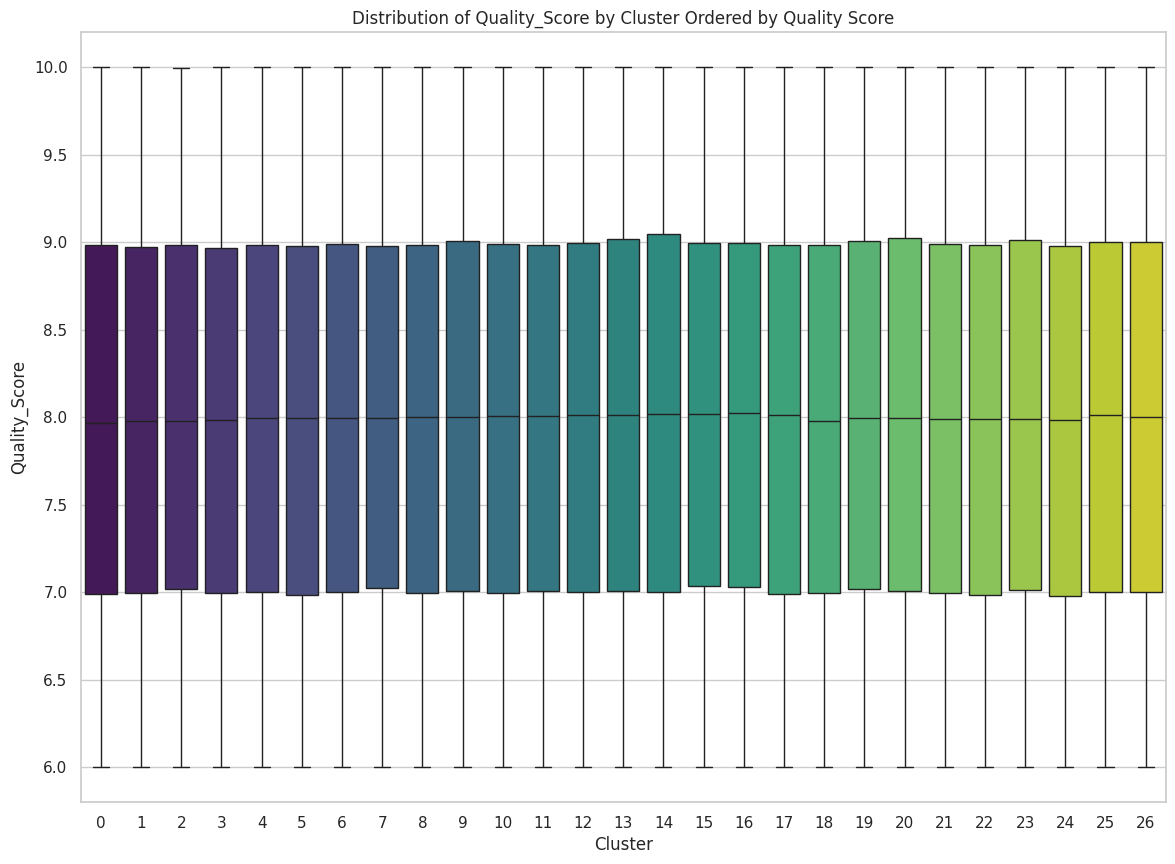

<ipython-input-19-9ee45db04ceb>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

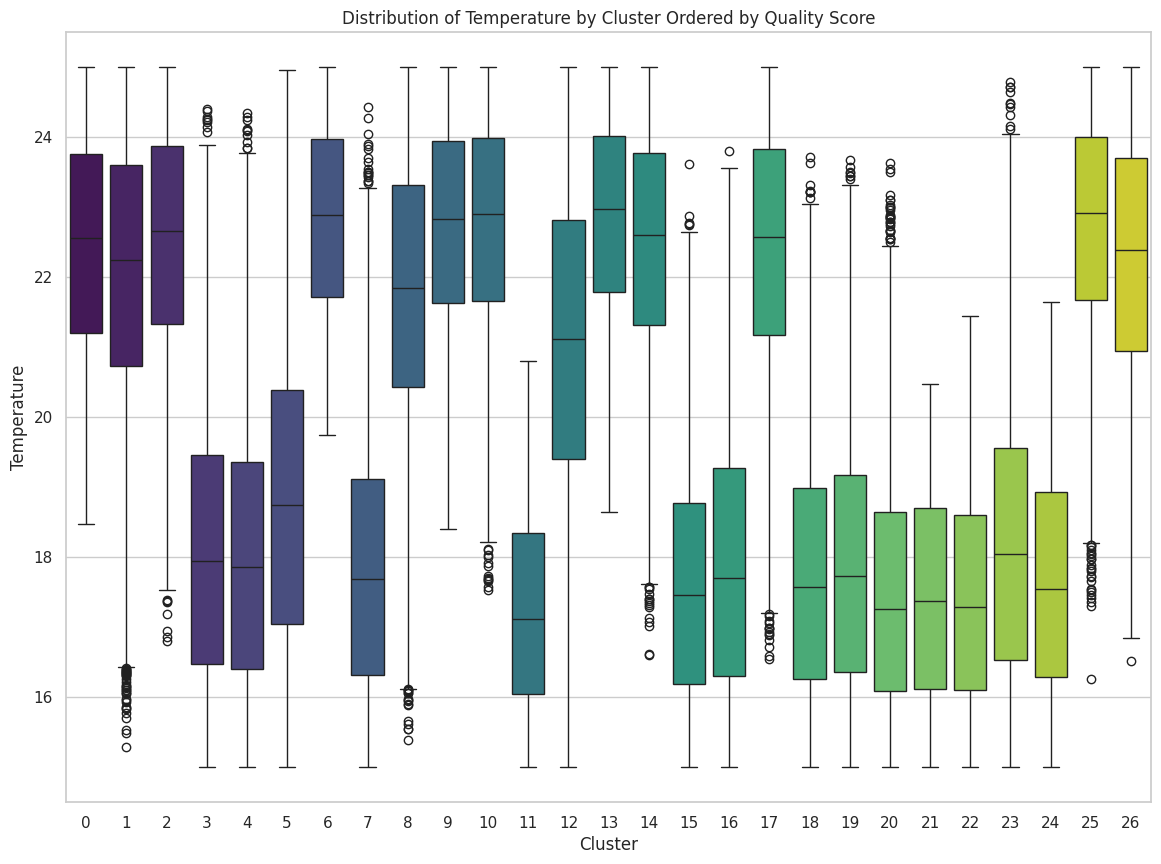

<ipython-input-19-9ee45db04ceb>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

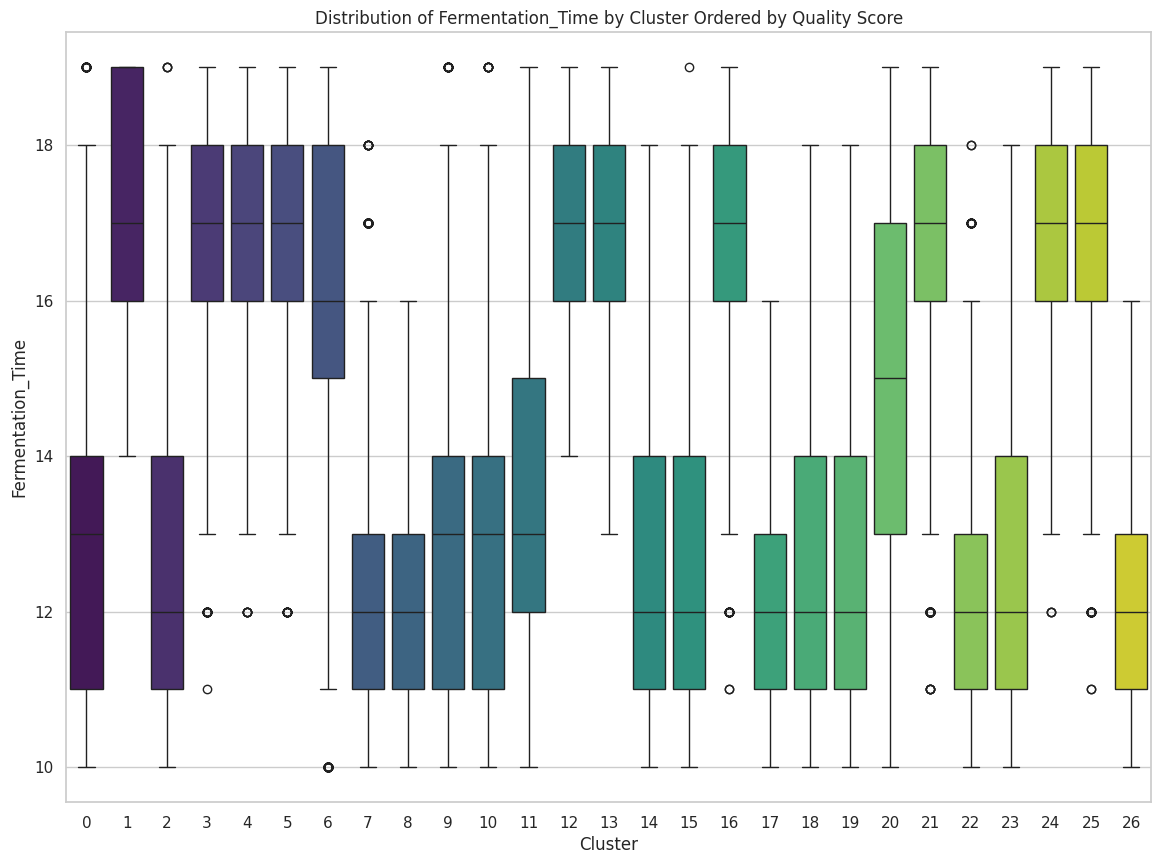

<ipython-input-19-9ee45db04ceb>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

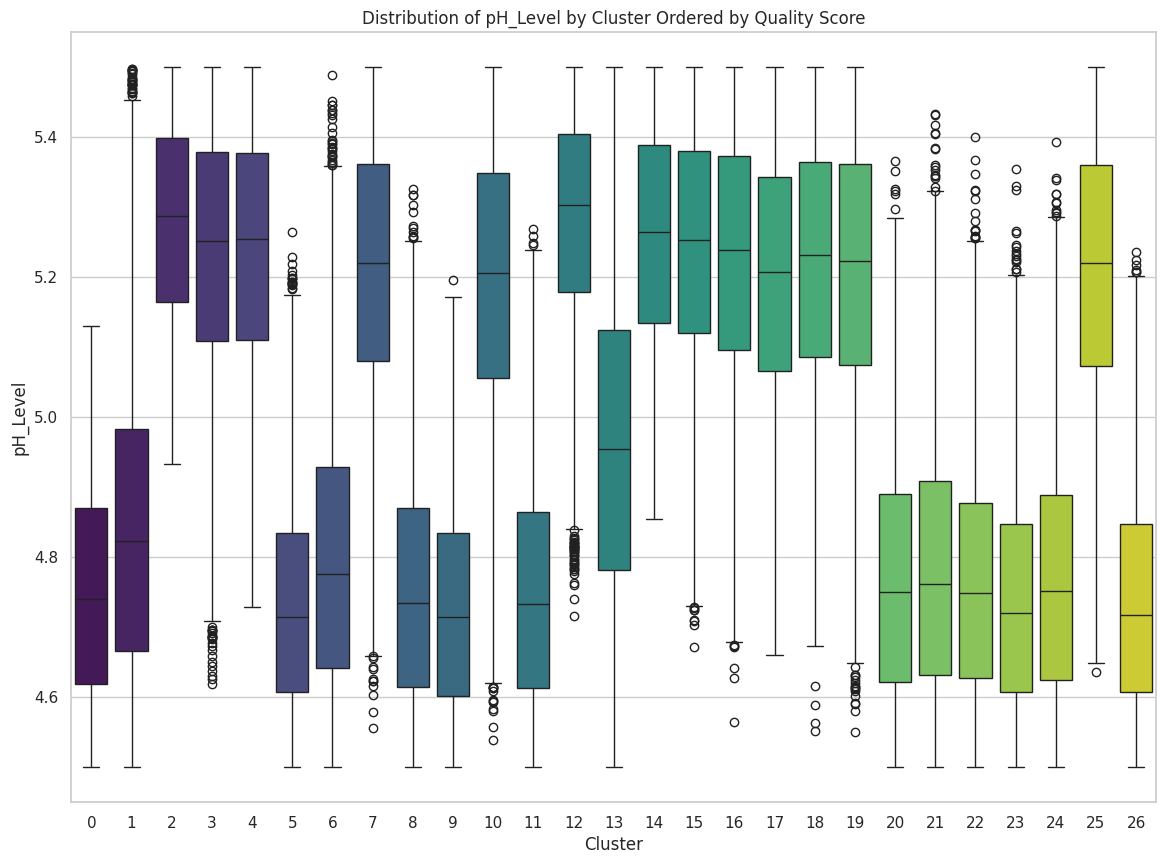

<ipython-input-19-9ee45db04ceb>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

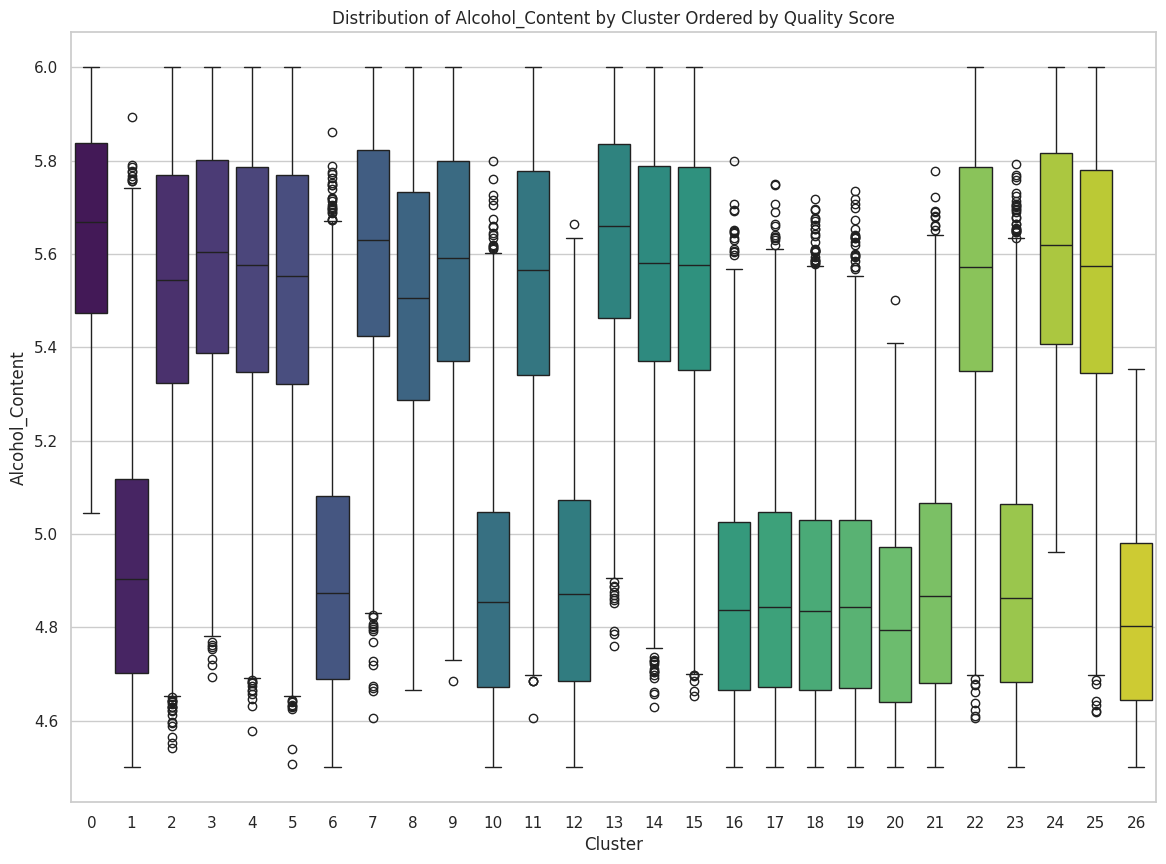

<ipython-input-19-9ee45db04ceb>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

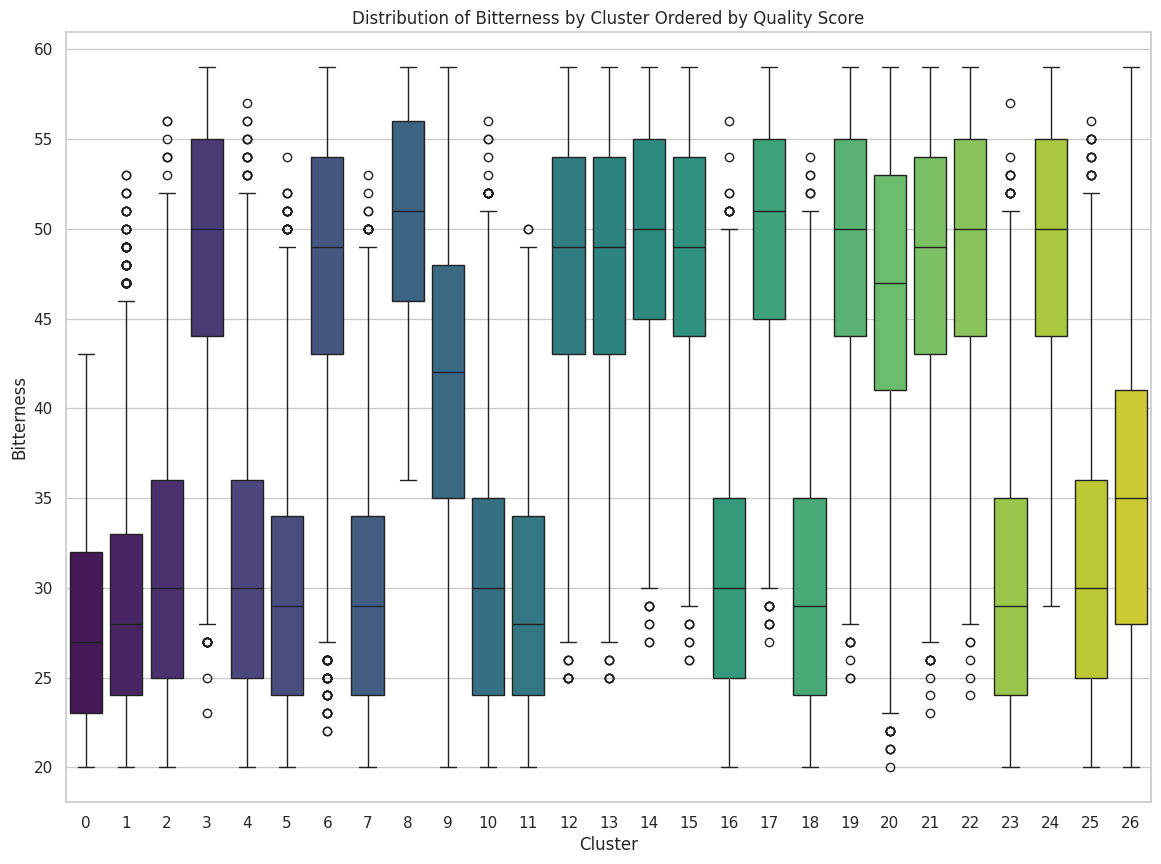

<ipython-input-19-9ee45db04ceb>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

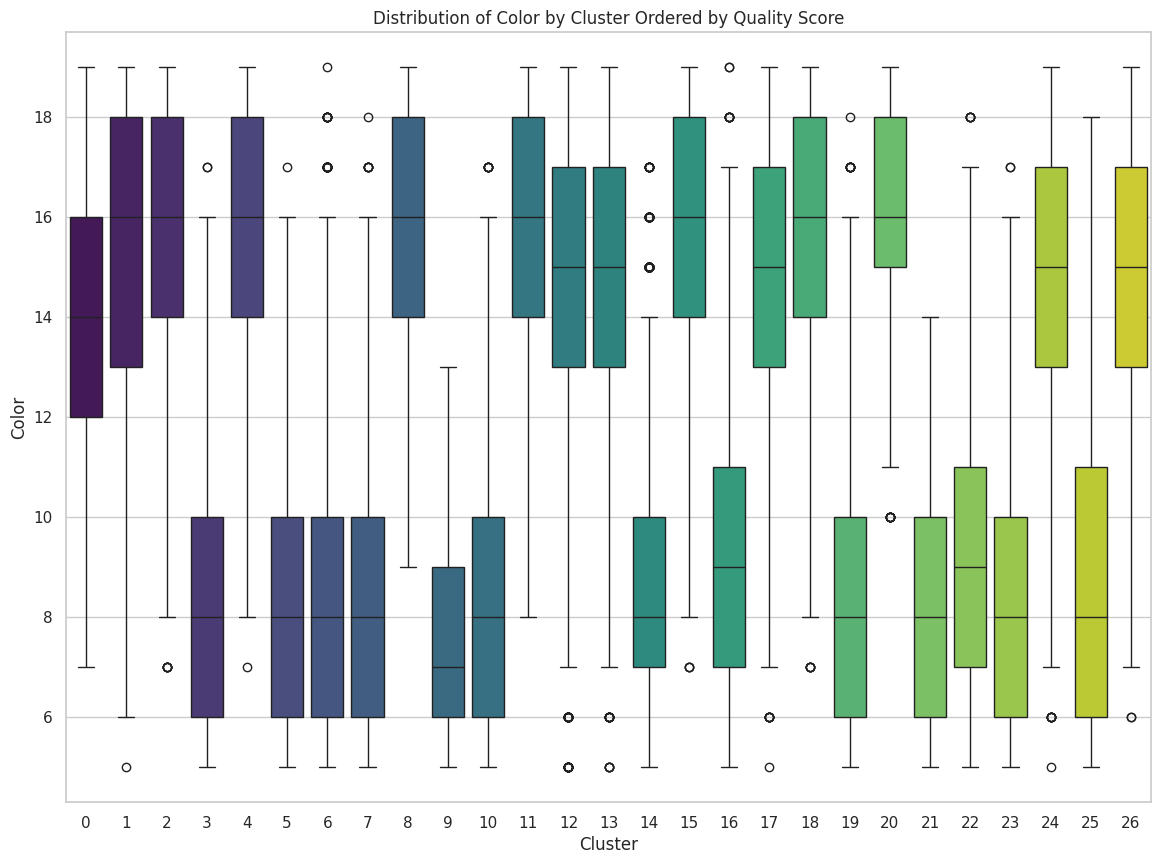

Data transformation execution time: 40.47 seconds


In [19]:
# Start the timer
start_time = time.time()

# Calculate the median quality score for each cluster
cluster_medians = beer_clustered.groupBy('Cluster').agg(expr('percentile_approx(Quality_Score, 0.5)').alias('median_Quality_Score'))
cluster_order = [row['Cluster'] for row in cluster_medians.orderBy('median_Quality_Score').collect()]

# Create a new column 'Cluster_Order' with the ordered cluster categories
cluster_mapping_expr = when(col('Cluster') == cluster_order[0], lit(0))
for i, cluster in enumerate(cluster_order[1:], 1):
    cluster_mapping_expr = cluster_mapping_expr.when(col('Cluster') == cluster, lit(i))

beer_clustered = beer_clustered.withColumn('Cluster_Order', cluster_mapping_expr)

# Convert the 'Cluster_Order' column to integer type
beer_clustered = beer_clustered.withColumn('Cluster_Order', col('Cluster_Order').cast('int'))

# Convert the DataFrame to Pandas for plotting
beer_clustered_pd = beer_clustered.toPandas()

# Ensure the DataFrame is sorted by Cluster_Order
beer_clustered_pd = beer_clustered_pd.sort_values(by='Cluster_Order') #doesn't seem to be working

# Generate a palette based on the custom colormap for the clusters
#cluster_palette = sns.color_palette([srm_colors_custom.get(c, "#000000") for c in sorted(beer_clustered_pd['Cluster_Order'].unique())])

# Plot the box plots using the ordered clusters
features_to_plot = ['Quality_Score', 'Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

for feature in features_to_plot:
    plt.figure(figsize=(14, 10))
    sns.boxplot(x='Cluster_Order', y=feature, data=beer_clustered_pd, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster Ordered by Quality Score')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

    # Save the plot as an image with better layout
    filename = "cluster_box_plots.jpg"
    plt.savefig(filename, bbox_inches='tight')

    # Download the file
    files.download("cluster_box_plots.jpg")

    # Show the plot
    plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

In [20]:
# Start the timer
start_time = time.time()

print(cluster_order)
beer_clustered.select('Cluster', 'Cluster_Order').distinct().show(28)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

[22, 0, 25, 3, 14, 12, 23, 26, 8, 1, 2, 13, 20, 9, 10, 16, 4, 5, 6, 19, 17, 21, 18, 7, 11, 24, 15]
+-------+-------------+
|Cluster|Cluster_Order|
+-------+-------------+
|      8|            8|
|     15|           26|
|     18|           22|
|     23|            6|
|     21|           21|
|     13|           11|
|      9|           13|
|     20|           12|
|     26|            7|
|     16|           15|
|      0|            1|
|      1|            9|
|      2|           10|
|     19|           19|
|      6|           18|
|      7|           23|
|     17|           20|
|      5|           17|
|     12|            5|
|     10|           14|
|     11|           24|
|     14|            4|
|     25|            2|
|      3|            3|
|     24|           25|
|      4|           16|
|     22|            0|
+-------+-------------+

Data transformation execution time: 2.06 seconds


In [21]:
# Start the timer
start_time = time.time()

cluster_medians.show(28)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

+-------+--------------------+
|Cluster|median_Quality_Score|
+-------+--------------------+
|      4|    8.02380097335235|
|      8|  7.9998351506101395|
|     23|    7.99539720905359|
|      7|   9.999748615366453|
|     26|  7.9965740127500125|
|     10|   8.015777078896352|
|     12|  7.9949498525525176|
|     22|   7.968513594051791|
|     25|   7.980693056382476|
|     24|   9.999921655037316|
|      1|   8.003203695393946|
|     21|   9.999638393504688|
|     13|   8.008009977307697|
|     16|   8.018181961775497|
|      6|   9.999124991223617|
|      3|   7.982058138447279|
|     20|   8.011076678917346|
|     11|    9.99978216968142|
|      5|   9.999033175416779|
|     14|  7.9941119016227695|
|     19|   9.999384906622792|
|      2|   8.007749586176134|
|     15|    9.99994147516682|
|     17|   9.999547265052756|
|      9|   8.011808009760315|
|      0|  7.9776041816345975|
|     18|   9.999675736846466|
+-------+--------------------+

Data transformation execution time: 0.

The clusters were ordered by the median beer quality to visually and comparibly order the cluters to potentially separate any clusters that showed either remarkable qualities or completely undesirable qualities.

Generally, the feature distributions by cluster ordered by quality score showed a bimodal distribution.  Indicating that some more structure in the data is becoming visable.

Observations:
Quality Score Distribution:
The distribution of the quality score across clusters shows some distinct separation, indicating the potential for identifying high and low-quality clusters.

Temperature:
The temperature distribution shows considerable variation between clusters. Higher quality clusters tend to have a more consistent temperature range, whereas lower quality clusters show more variability.

Fermentation Time:
Clusters with higher quality scores generally exhibit longer fermentation times, suggesting a correlation between fermentation duration and beer quality.

pH Level:
The pH level distributions indicate that higher quality clusters maintain a slightly higher pH range, potentially contributing to the desired flavor profile.

Alcohol Content:
Higher quality clusters typically have a slightly higher alcohol content, which might be a factor in the overall beer quality.

Bitterness:
The bitterness distribution is more varied, but higher quality clusters tend to have moderate bitterness levels, avoiding extremes.

Color:
The color distributions show that certain color ranges are associated with higher quality clusters, suggesting that color may be a visual indicator of quality.

Conclusion:
The clustering results suggest that certain features, such as fermentation time, temperature, pH level, alcohol content, and color, have noticeable patterns when associated with beer quality. These findings highlight areas for further investigation to refine the brewing process and enhance the quality of the final product. By understanding these feature distributions, the brewery can make informed decisions to optimize their recipes and brewing techniques.

## Deep Dive; Deriving Chemistry Data

Arguments can be made to add in the derived data earlier or later. For this project, because it's a derived and not raw data, it will be included only for the ML models. This is because derived data could influence the unsupervised kmeans clustering algorithm by putting clusters together showing relationships that don't really exist.

Some ideas for using ChemPy in this brewing analysis:


**pH and Mineral Content:**
Use ChemPy to model how different mineral compositions in water (calcium, magnesium) affect the pH during mashing and how this influences enzyme activity and starch conversion.

**Fermentation Dynamics:**
Model fermentation reactions to understand how different yeast strains (temperature and fermentation time) convert sugars to alcohol and CO2, impacting the final quality and flavor profile of the beer.

**Ingredient Interactions:**
Analyze how different ratios of malts and hops interact chemically during the brewing process and their cumulative impact on beer quality.

**Integrating ChemPy with Machine Learning
for more advanced analysis: (see phase 3 project for a demo of this technique)**
Integrate ChemPy with machine learning tools like scikit-learn to predict quality scores based on chemical composition and brewing conditions

**Feature Engineering:**
Use ChemPy to calculate chemical properties (e.g., reaction rates, equilibrium constants) and use these as features for machine learning models.

Looking at derived pH data, can be helpful as it can provide context and information about the brewing environment that impacts the behavior of reactants in the measured data.

In this experiment, buffer capacities will be explored. Different malt and hops types have different buffering capacities, affecting the pH differently.

A note about the calculation, by incorporating malt and hops types into the buffer system calculation, the buffering capacity can be adjusted based on the specific ingredients used.

This method improves understanding of the system by providing a more details of how the initial pH and buffering capacities impact the final beer quality.


In [22]:
# Start the timer
start_time = time.time()

# Display the schema of the DataFrame
beer_encoded.printSchema()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

root
 |-- pH_Level: double (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- Water_Ratio: double (nullable = false)
 |-- Malt_Ratio: float (nullable = true)
 |-- Hops_Ratio: float (nullable = true)
 |-- Malt_Hops_Ratio: double (nullable = true)
 |-- Malt_Type: string (nullable = false)
 |-- Hops_Type: string (nullable = false)
 |-- Beer_Style_Index: double (nullable = false)
 |-- Beer_Style_Vec: vector (nullable = true)
 |-- Malt_Type_Index: double (nullable = false)
 |-- Malt_Type_Vec: vector (nullable = true)
 |-- Hops_Type_Index: double (nullable = false)
 |-- Hops_Type_Vec: vector (nullable = true)

Data transformation execution time: 0.00 seconds


Resources were sufficient to process the entire sample dataset using K-Means clustering. However, due to the resource-intensive nature of the chemistry analysis and machine learning modeling, the data was further subsampled for the subsequent analyses.


In [ ]:
# Start the timer
start_time = time.time()

# Mount Google Drive to save and load checkpoints
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Brewing_Chemistry/Models/'
os.makedirs(drive_path, exist_ok=True)

def save_checkpoint(obj, filename):
    """
    Save an object to a checkpoint file using pickle.

    Parameters:
    obj : object
        The object to be saved.
    filename : str
        The name of the file to save the object to.
    """
    filepath = os.path.join(drive_path, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Checkpoint saved to {filepath}")

def load_checkpoint(filename):
    """
    Load an object from a checkpoint file using pickle.

    Parameters:
    filename : str
        The name of the file to load the object from.

    Returns:
    object
        The loaded object.
    """
    filepath = os.path.join(drive_path, filename)
    with open(filepath, 'rb') as f:
        obj = pickle.load(f)
    print(f"Checkpoint loaded from {filepath}")
    return obj

    # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

In [23]:
# Start the timer
start_time = time.time()

# Sample 19% of the rows with a seed for reproducibility (about 50,000 data points)
beer_encoded_sampled = beer_encoded.sample(withReplacement=False, fraction=0.19, seed=42)
save_checkpoint(beer_encoded_sampled, 'beer_encoded_sampled_checkpoint.pkl')

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

Data transformation execution time: 0.00 seconds


In [24]:
# Start the timer
start_time = time.time()

beer_encoded_sampled.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

+------------------+----------------+-----------------+------------------+------------------+----------+-----+------------------+----------+-----------+----------+----------+------------------+---------+------------+----------------+--------------+---------------+-------------+---------------+-------------+
|          pH_Level|Ingredient_Ratio|Fermentation_Time|       Temperature|   Alcohol_Content|Bitterness|Color|     Quality_Score|Beer_Style|Water_Ratio|Malt_Ratio|Hops_Ratio|   Malt_Hops_Ratio|Malt_Type|   Hops_Type|Beer_Style_Index|Beer_Style_Vec|Malt_Type_Index|Malt_Type_Vec|Hops_Type_Index|Hops_Type_Vec|
+------------------+----------------+-----------------+------------------+------------------+----------+-----+------------------+----------+-----------+----------+----------+------------------+---------+------------+----------------+--------------+---------------+-------------+---------------+-------------+
|5.4555000887623075|     1:0.30:0.30|               12|16.270818490984684

In [25]:
# Start the timer
start_time = time.time()

# Define buffer capacities
malt_buffer_capacities = {
    'Barley': 0.1,
    'Wheat': 0.2,
    'Rye': 0.15,
    'Oats': 0.05
}

hops_buffer_capacities = {
    'Bittering': 0.2,
    'Dual Purpose': 0.1,
    'Aroma': 0.05
}

# Define the buffer system function for PySpark
def buffer_system_with_types_spark(final_pH, malt_type, hops_type, malt_ratio, hops_ratio):
    """
    Simulates the buffering system in a brewing process based on the final pH,
    malt type, hops type, malt ratio, and hops ratio.

    Parameters:
    final_pH (float): The final pH value of the beer.
    malt_type (str): The type of malt used in the brewing process.
    hops_type (str): The type of hops used in the brewing process.
    malt_ratio (float): The ratio of malt used in the brewing process.
    hops_ratio (float): The ratio of hops used in the brewing process.

    Returns:
    float: The initial pH value calculated from the buffering system.

    Raises:
    Exception: If an error occurs during processing.
    """
    try:
        print(f"Processing row with: final_pH={final_pH}, malt_type={malt_type}, hops_type={hops_type}, malt_ratio={malt_ratio}, hops_ratio={hops_ratio}")

        # Phosphate buffer example
        H2PO4 = Species.from_formula('H2PO4-')
        HPO4 = Species.from_formula('HPO4-2')
        H = Species.from_formula('H+')
        OH = Species.from_formula('OH-')
        H2O = Species.from_formula('H2O')

        phosphate_buffer = Equilibrium({'H2PO4-'}, {'H+', 'HPO4-2'}, 10**-7.2)
        water_autop = Equilibrium({'H2O'}, {'H+', 'OH-'}, 10**-14)
        substances = [H2O, OH, H, H2PO4, HPO4]

        eqsys = EqSystem([phosphate_buffer, water_autop], substances)

        # Get buffering capacities based on malt and hops types
        malt_buffer = malt_buffer_capacities.get(malt_type, 0.1)
        hops_buffer = hops_buffer_capacities.get(hops_type, 0.1)

        concentrations = defaultdict(float, {
            'H2PO4-': malt_ratio * malt_buffer,
            'HPO4-2': hops_ratio * hops_buffer,
            'H2O': 1.0
        })

        print("Concentrations:", concentrations)

        def residual(H_conc):
            """
            Calculate the residual between the current hydrogen ion concentration
            and the equilibrium concentration.

            Parameters:
            H_conc (array-like): Initial guess for the hydrogen ion concentration.

            Returns:
            float: The difference between the current hydrogen ion concentration
                   and the equilibrium concentration.
            """
            concentrations['H+'] = H_conc[0]
            arr, sol, sane = eqsys.root(concentrations)
            conc = dict(zip(eqsys.substances, arr))
            return conc['H+'] - H_conc[0]

        H_initial, = fsolve(residual, [10**-final_pH])
        initial_pH = -log10(H_initial)

        print(f"Initial pH: {initial_pH}")

        return float(initial_pH)
    except Exception as e:
        print(f"Error in buffer_system_with_types_spark: {e}")
        return None

# Register the UDF (user-defined function)
buffer_system_udf = udf(buffer_system_with_types_spark, DoubleType())

# Apply UDF to DataFrame with inferred malt and hops types
beer_encoded_sampled = beer_encoded_sampled.withColumn(
    'Estimated_Initial_pH',
    buffer_system_udf(
        col('pH_Level'),
        col('Malt_Type'),
        col('Hops_Type'),
        col('Malt_Ratio'),
        col('Hops_Ratio')
    )
)

# Print the first 5 rows of the Estimated_Initial_pH column
beer_encoded_sampled.select('Estimated_Initial_pH').show(5)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


+--------------------+
|Estimated_Initial_pH|
+--------------------+
|   6.898968283565985|
|   6.882577666599115|
|   6.941165514203103|
|   6.524510171325222|
|    7.30913886605153|
+--------------------+
only showing top 5 rows

Data transformation execution time: 421.44 seconds


In [ ]:
#might be faster

# Start the timer
start_time = time.time()

# Check for NaN values in the 'Estimated_Initial_pH' column
nan_count = beer_encoded_sampled.filter(beer_encoded_sampled['Estimated_Initial_pH'].isNull()).count()
print(f"Number of NaN values: {nan_count}")

# Print rows with NaN values for inspection (limit to 10 rows for readability)
if nan_count > 0:
    print("Rows with NaN values:")
    beer_encoded_sampled.filter(beer_encoded_sampled['Estimated_Initial_pH'].isNull()).show(10)

# Drop rows with NaN values in 'Estimated_Initial_pH' or 'Quality_Score'
beer_encoded_clean = beer_encoded_sampled.dropna(subset=['Estimated_Initial_pH', 'Quality_Score'])

# Convert to Pandas DataFrame for visualization (only after cleaning and reducing the size)
beer_encoded_pH_pd = beer_encoded_clean.toPandas()

# Create the Facet Grid
g = sns.FacetGrid(beer_encoded_pH_pd, col="Beer_Style", col_wrap=4, height=4, sharex=True, sharey=True)

# Map the scatter plot to the grid
g.map(sns.scatterplot, "Quality_Score", "Estimated_Initial_pH")

# Add titles and labels
g.set_axis_labels("Quality Score", "Estimated Initial pH")
g.set_titles(col_template="{col_name} Beer")

# Save the plot as an image with better layout
filename = "initial_pH_scatter.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("initial_pH_scatter.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


The scatter plot shows the relationship between the Estimated Initial pH and the Quality Score of beer samples. The points are fairly evenly distributed across the range of Estimated Initial pH values, with no obvious trend or pattern linking pH levels to quality scores. This suggests that the initial pH might not be a significant predictor of beer quality within this dataset, or that other factors could be more influential in determining the quality score. The range of pH values appears to cluster around the neutral pH range (6.0 to 7.5), which is typical for beer, but without a clear correlation to higher or lower quality scores.


# Supervised Experiments

The following experiments incorporate both numeric and encoded categorical data to ensure comprehensive modeling.

In [27]:
# Start the timer
start_time = time.time()

# Check if checkpoint exists and load it
beer_encoded_sampled = load_checkpoint('beer_encoded_sampled_checkpoint.pkl')

# Define the feature columns
feature_columns = ['Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature',
                   'Alcohol_Content', 'Bitterness', 'Color', 'Beer_Style_Index', 'Malt_Type_Index',
                   'Hops_Type_Index', 'Estimated_Initial_pH']

# Assemble the feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
beer_encoded_sampled_vectorized = assembler.transform(beer_encoded_sampled)

# Select the features and label columns
data = beer_encoded_sampled_vectorized.select("features", col("Quality_Score").alias("label"))

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Print the count of rows in the training and testing sets
print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")

# Save intermediate results
save_checkpoint((train_data, test_data), 'train_test_split_checkpoint.pkl')

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


Training set size: 38342
Test set size: 9372
Data transformation execution time: 1533.72 seconds


A random seed was used to ensure the reproducibility of the experiment. All features were combined into a single vector, transforming a row with 10 columns into a vector with 10 dimensions—essentially a different way of packaging the data, as is typical in Spark processing.

# Random Forest Experiment

In [29]:
# Path to save/load the Random Forest model
#rf_model_path = "/Brewing_Chemistry/Models/best_rf_model.pkl"

# Path to save/load the Random Forest model
rf_model_path = os.path.join(drive_path, "best_rf_model.pkl")

# Check if the model is already saved
if os.path.exists(rf_model_path):
    # Load the model
    cvModel = load_model(rf_model_path)
else:
    # Start the timer
    start_time = time.time()

# Define the RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label', seed=42)

# Define the parameter grid (reduced size for testing)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1]) \
    .build()

# Define the parameter grid (reduced size for testing)
#paramGrid = ParamGridBuilder() \
 #   .addGrid(rf.numTrees, [50, 500, 1500]) \
 #   .addGrid(rf.maxDepth, [5]) \
 #   .addGrid(rf.minInstancesPerNode, [1, 2]) \
 #   .build()

# Define the parameter grid (testing progression to get an r value greater than zero)
#paramGrid = ParamGridBuilder() \
   #.addGrid(rf.numTrees, [50, 1000, 10000]) \ # 1 million data points; how many trees needed would be expected to perform well (less number of data points, same, or more?1,000 then 10,000)
   #.addGrid(rf.maxDepth, [5, 30]) \  # 10, 50, 100, 200
   #.addGrid(rf.minInstancesPerNode, [1, 2]) \  # 1, 2, 10
   #.build()

#see if there are any other parameters that need to be tuned: criterion

# Define the evaluator
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

# Define the CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=2)  # Reduced parallelism for limited resources

# Fit the model
cvModel = crossval.fit(train_data)

# Save the best model to avoid retraining
save_checkpoint(cvModel, rf_model_path)

# Get the best model
best_rf_model = cvModel.bestModel

# Print the best hyperparameters found
best_rf_params = best_rf_model.extractParamMap()
for param, value in best_rf_params.items():
    print(f"{param.name}: {value}")

# Print all parameters and their values for the best model
#print(best_rf_model.explainParams())

# Predict on the test set
predictions = best_rf_model.transform(test_data)

# Evaluate the best model on the test set
r2_score_best = evaluator.evaluate(predictions)
print(f"R^2 score of the best model: {r2_score_best}")

# Feature importances
importances = best_rf_model.featureImportances

# Convert feature importances to a pandas DataFrame
importances_df = pd.DataFrame(importances.toArray(), index=feature_columns, columns=['Importance'])

# Plot the feature importances
plt.figure(figsize=(14, 8))
importances_df.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')

# Save the plot as an image with better layout
filename = "RF_importance_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("RF_importance_plot.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")


KeyboardInterrupt: 

positive r^2 score, time it took to run, top 3 features

print the top RF paramteres...

# Gradient Boosted Tree Experiment

In [ ]:
# Path to save/load the Gradient Boosting model
#gbr_model_path = "/Brewing_Chemistry/Models/best_gb_model.pkl"

# Path to save/load the Gradient Boosting model
gbr_model_path = os.path.join(drive_path, "best_gb_model.pkl")

# Check if the model is already saved
if os.path.exists(gbr_model_path):
    # Load the model
    cvModel_gb = load_model(gbr_model_path)
else:
    # Start the timer
    start_time = time.time()

# Split the data into training and testing sets
train_data, test_data = beer_encoded_sampled_vectorized.randomSplit([0.8, 0.2], seed=42)

# Initialize the Gradient Boosting Regressor
gbr = GBTRegressor(featuresCol="features", labelCol="Quality_Score", seed=42)

# Define the parameter grid (baseline)
paramGrid = ParamGridBuilder() \
    .addGrid(gbr.maxIter, [100, 200]) \
    .addGrid(gbr.maxDepth, [3, 4]) \
    .addGrid(gbr.stepSize, [0.01, 0.05]) \
    .build()

# Define the parameter grid (advanced)
#paramGrid = ParamGridBuilder() \
#    .addGrid(gbr.maxIter, [100, 200, 300, 400]) \
#    .addGrid(gbr.maxDepth, [3, 4, 5]) \
#    .addGrid(gbr.stepSize, [0.01, 0.05, 0.1]) \
#    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="Quality_Score", predictionCol="prediction", metricName="r2")

# Initialize CrossValidator
crossval = CrossValidator(estimator=gbr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=4)

# Fit the model
cvModel = crossval.fit(train_data)

# Save the best model to avoid retraining
save_checkpoint(cvModel, gbr_model_path)

# Get the best model
best_gbr_model = cvModel.bestModel

# Print the best hyperparameters found
best_gbr_params = best_gbr_model.extractParamMap()
for param, value in best_gbr_params.items():
    print(f"{param.name}: {value}")

# Print all parameters and their values for the best model
#print(best_gbr_model.explainParams())

# Predict on the test set
predictions = best_gbr_model.transform(test_data)

# Evaluate the model
r2_score_best = evaluator.evaluate(predictions)
print(f"R^2 score of the best Gradient Boosting model: {r2_score_best}")

# Feature importances
importances = best_gbr_model.featureImportances

# Plot feature importances
# Convert feature importances to a pandas DataFrame
importances_gbr = pd.DataFrame(importances.toArray(), index=feature_columns, columns=['Importance'])

# Plot the feature importances
plt.figure(figsize=(14, 8))
importances_gbr.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.title('Feature Importances from Gradient Boosting Regressor')
plt.ylabel('Importance Score')

# Save the plot as an image with better layout
filename = "GBR_importance_plot.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("GBR_importance_plot.jpg")

# Show the plot
plt.show()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

negative r^2 score, time it took to run, top 3 features

mentoin top parameters

In [ ]:
# Start the timer
start_time = time.time()

 # Stop Spark session
spark.stop()

 # Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")

# Conclusion


# Summary

The objective was to develop an automated essay scoring model leveraging different machine learning techniques. The analysis involved three models: a Neural Network with TF-IDF vectorization, K-Means clustering with TF-IDF vectorization, and a BERT-based model.

#### **Key Findings:**
<ol>
  <li><strong>
TF-IDF Vectorization with Neural Network</strong></ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy: 88.5%
<li>Test Accuracy: 41.4%
</ul>

Observation: High training accuracy with significantly lower test accuracy indicates overfitting.

<ol start ="2">
<li><strong>
TF-IDF Vectorization with K-Means Clustering</strong>
</ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy: 100%
<li>Test Accuracy: 41.2%
</ul>

Observation: Perfect train accuracy due to the nature of clustering but poor generalization to test data, highlighting overfitting.

<ol start ="3">
<li><strong>
BERT-Based Model</strong>
</ol>

Evaluation Metrics:
<ul>
<li>Train Accuracy: 84.6%
<li>Test Accuracy: 52.8%
</ul>

Observation: Balanced performance with a higher test accuracy, indicating better generalization capabilities.

#### **Recommendations**
<ul>
<li><strong>Adopt the BERT-Based Model</strong>

Justification: The BERT model demonstrated the best balance between train and test accuracy, indicating strong generalization capabilities.
<li><strong>Mitigate Overfitting in Neural Network Models</strong>

Strategies: Consider regularization techniques, dropout adjustments, or tuning hyperparameters such as learning rate and batch size to improve generalization.
<li><strong>Expand Training Data</strong>

Rationale: Increasing the sample size can help in reducing overfitting and improving the model's ability to generalize to new data.
<li><strong>Further Explore Transformer-Based Models</strong>

Reasoning: Given the superior performance of the BERT model, exploring other transformer architectures or fine-tuning strategies could yield even better results.
<li><strong>Continuous Monitoring and Validation</strong>

Action: Regularly update the model with new data and validate its performance to ensure it remains effective and relevant.
</ul>

By implementing these recommendations, the goal of providing reliable and efficient automated essay scoring can be achieved, ultimately supporting educators in delivering timely and consistent feedback to students.

# Experimental Limitations

# Next Steps

# References:

1. https://brookstonbeerbulletin.com/thinking-about-beer-color/
2. https://homebrewing.org/pages/srm-beer-color-scale
3. https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset/data
4. https://www.kaggle.com/code/diegoamd/brewery-dataset-eda-regression-and-clustering
5. https://blogs.cornell.edu/brewing/resources/
6. https://www.craftmasterstainless.com/blog/2023/11/21/a-guide-to-the-complex-chemistry-behind-beer-brewing
7. https://beaconhillsbrewhouse.wordpress.com/2011/09/18/water-chemistrys-influence-on-my-oktoberfest-beer/
8. https://spikebrewing.com/blogs/learn/primary-ingredients-for-brewing-beer
9. https://byo.com/article/understanding-residual-alkalinity-ph/
10. https://www.google.com/search?q=types+of+beer+yeast&sca_esv=f07dd38fdcfe8355&rlz=1C5CHFA_enUS504US504&ei=h0VwZt2lLuGeptQPxpuFiAE&ved=0ahUKEwidhcuH6uKGAxVhj4kEHcZNAREQ4dUDCBA&uact=5&oq=types+of+beer+yeast&gs_lp=Egxnd3Mtd2l6LXNlcnAaAhgDIhN0eXBlcyBvZiBiZWVyIHllYXN0MgsQABiABBiRAhiKBTIGEAAYFhgeMgYQABgWGB4yCRAAGBYYiwMYHjIJEAAYFhiLAxgeMgYQABgWGB4yBhAAGBYYHjILEAAYFhiLAxgeGA8yCRAAGBYYiwMYHjIJEAAYFhiLAxgeSOoVUJgEWLMTcAF4AZABAJgBjQGgAZsHqgEDNC41uAEDyAEA-AEBmAIKoAK9B8ICChAAGLADGNYEGEfCAgoQABiABBhDGIoFwgIOEAAYgAQYhgMYigUYiwPCAgsQABiABBiiBBiLA8ICBRAAGIAEwgIIEAAYFhgeGA_CAgsQABgWGAoYiwMYHsICCxAAGIAEGIYDGIoFwgIIEAAYgAQYogSYAwCIBgGQBgiSBwM1LjWgB5E8&sclient=gws-wiz-serp
11. https://www.micetgroup.com/the-business-competition-strategy-of-craft-brewery/
12. https://www.brewersassociation.org/directories/breweries/?location=United%20States&type=Regional
13. https://www.brewersassociation.org/programs/beer-food-program/
14. https://beersmith.com/blog/2016/02/11/the-sulfate-to-chloride-ratio-and-beer-bitterness/
15. https://www.nature.com/articles/s41467-024-46346-0
16. https://www.nature.com/scitable/topicpage/yeast-fermentation-and-the-making-of-beer-14372813/





In [ ]:
# Show the total number of rows in the DataFrame
total_rows = beer_encoded_sampled.count()
print(f"Total number of rows: {total_rows}")

# Show the first few rows to verify the data
beer_encoded_sampled.show(5)


why were some rows dropped? why not 25,000?

In [ ]:
#Revert to google colab default environment

# Uninstall installed packages
!pip uninstall -y findspark
!rm -rf /content/spark-3.1.2-bin-hadoop2.7
!rm spark-3.1.2-bin-hadoop2.7.tgz

# Reset environment variables
os.environ.pop("JAVA_HOME", None)
os.environ.pop("SPARK_HOME", None)

# Optional: Restart the runtime (this will disconnect and reset the environment)
import os
os.kill(os.getpid(), 9)


Checking for NaN values in the 'Estimated_Initial_pH' column
Number of NaN values: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

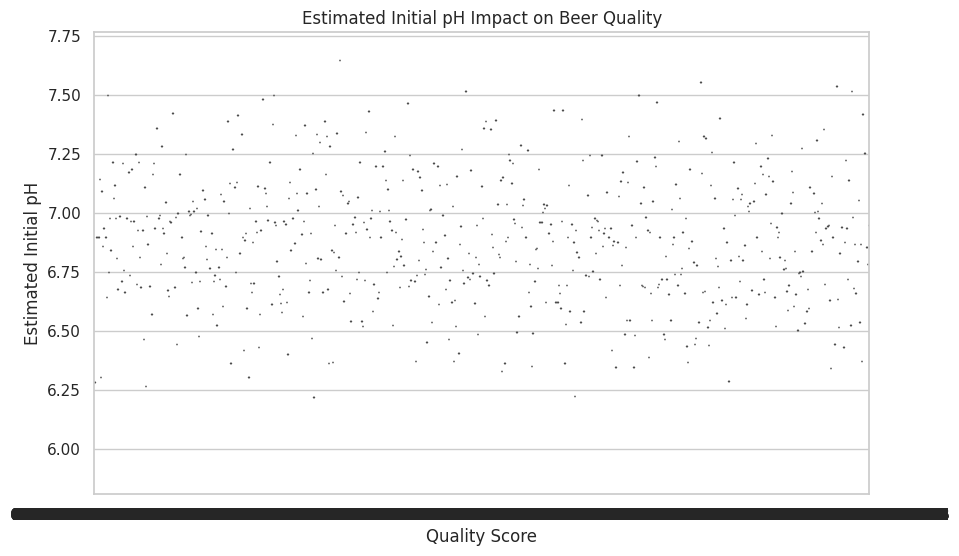

KeyError: 'Beer_Type'

In [26]:
|# Start the timer
start_time = time.time()

# Convert to Pandas DataFrame for visualization
beer_encoded_pH_pd = beer_encoded_sampled.toPandas()

# Check for NaN values and remove them
print("Checking for NaN values in the 'Estimated_Initial_pH' column")
nan_count = beer_encoded_pH_pd['Estimated_Initial_pH'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Print rows with NaN values for inspection
if nan_count > 0:
    print("Rows with NaN values:")
    print(beer_encoded_pH_pd[beer_encoded_pH_pd['Estimated_Initial_pH'].isna()])

# Create the Facet Grid
#g = sns.FacetGrid(beer_encoded_pH_pd, col="Beer_Type", col_wrap=4, height=4, sharex=True, sharey=True)

# Map the scatter plot to the grid
g.map(sns.scatterplot, "Quality_Score", "Initial_pH")

# Add titles and labels
g.set_axis_labels("Quality Score", "Initial pH")
g.set_titles(col_template="{col_name} Beer")

# Save the plot as an image with better layout
filename = "initial_pH_scatter.jpg"
plt.savefig(filename, bbox_inches='tight')

# Download the file
files.download("initial_pH_scatter.jpg")

# Show the plot
plt.show()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Data transformation execution time: {elapsed_time:.2f} seconds")